In [1]:
import pandas as pd
import re
import os
import glob
import snapatac2 as snap
from statsmodels.stats.multitest import multipletests

import seaborn as sns
import numpy as np
import utils
import subprocess

from pybedtools import BedTool
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_contents
from matplotlib_venn import venn2
import pyBigWig

In [2]:
annotations = [
    "/data2st1/junyi/generegion_vM23/intron_selected.bed",
    "/data2st1/junyi/generegion_vM23/exon_selected.bed",
    "/data2st1/junyi/generegion_vM23/promoter2k.bed",
    #"/data2st1/junyi/generegion_vM23/repeat.bed",
    "/data2st1/junyi/output/atac0416/cCRE/LINE.bed",
    "/data2st1/junyi/output/atac0416/cCRE/SINE.bed",
    "/data2st1/junyi/output/atac0416/cCRE/LTR.bed",
    "/data2st1/junyi/output/atac0416/cCRE/cpg.bed",
    "/data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed",    
    "/data2st1/junyi/generegion_vM23/UTR.bed",
    "/data2st1/junyi/generegion_vM23/CDS.bed",
    "/data2st1/junyi/generegion_vM23/genebody.bed",
    "/data2st1/junyi/output/atac0416/cCRE/intergenic.bed"
]

In [3]:
def merge_region(region='PFC',condition="MC",folder='/data2st1/junyi/output/atac0526/dar/region_nt/',method='mementob',blacklist=['Doublet','NN',"Neuron"]):
    df_result = pd.DataFrame()
    files = glob.glob(f'{folder}/{region}*{condition}_{method}.csv')
    for file in files:
        if any([file.find(black) > -1 for black in blacklist]):
            continue
        df_dar = pd.read_csv(file,index_col=0)

        ctname = file.split('/')[-1].replace('.csv', '')
        ctname = "_".join(ctname.split('_')[1:-2])
        if len(df_dar) == 0:
            continue
        df_dar['ctname'] = ctname
        df_result = pd.concat([df_result, df_dar], axis=0, ignore_index=True)
    df_result['region'] = region
    df_result['condition'] = condition
    return df_result

def intersect_bed_files(bed_file1, bed_file2):
    bed1 = BedTool(bed_file1)
    bed2 = BedTool(bed_file2)

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

def intersect_bed_objects(bed_file1, bed_file2):
    bed1 = bed_file1
    bed2 = bed_file2

    # Intersect and split regions
    # Retain annotations from bed_file2 for overlapping regions
    merged = bed1.intersect(bed2, wa=True, wb=True)#.saveas("output/temp_intersect.bed")

    # Split non-overlapping regions from bed_file1
    non_overlapping = bed1.subtract(bed2)#.saveas("output/temp_non_overlapping.bed")

    return merged, non_overlapping

def get_proity_region(df_in, priority = [
    "promoter",
    "UTR",
    "exon",
    "intron",
    "intergenic"   ]

):
    df_in['annotation'] = priority[-1]
    df_in = df_in.loc[:,priority+['id']]
    priorityi = priority[::-1]
    for column in priorityi:
        df_in.loc[df_in[column]==True,"annotation"] = column
    return df_in


def is_promoter(row,interval_col="names"):
    # 解析第一个区间
    chrom_part, pos_part = row[interval_col].split(':')
    start1, end1 = map(int, pos_part.split('-'))
    strand = row['strand']

    if strand == "+":
        # 如果是正链，start1和end1不变
        # 获取第二个区间
        start2 = row['gstart']-2000
        end2 = row['gstart']
    else:
        strand = "-"
        start2 = row['gend']
        end2 = row['gend']+2000
    # 判断是否有交集


In [4]:
method = 'mementoht'
folder = '/data2st1/junyi/output/atac0526/dar/region_nt/'

In [5]:
df_PFC_MC = merge_region(region='PFC',condition="MC",folder=folder,method=method)
df_PFC_MW = merge_region(region='PFC',condition="MW", folder=folder, method=method)
df_HIP_MC = merge_region(region='HIP',condition="MC",folder=folder,method=method)
df_HIP_MW = merge_region(region='HIP',condition="MW", folder=folder, method=method)
df_AMY_MC = merge_region(region='AMY',condition="MC",folder=folder,method=method)
df_AMY_MW = merge_region(region='AMY',condition="MW", folder=folder, method=method)
df_DAR_ALL = pd.concat([df_PFC_MC, df_PFC_MW, df_HIP_MC, df_HIP_MW, df_AMY_MC, df_AMY_MW], axis=0, ignore_index=True)

In [6]:
df_DAR_ALL.rename(columns={'gene': 'names'}, inplace=True)

In [7]:
df_annotattion = utils.annotate_region(df_DAR_ALL,region_col='names', bedfile='/data2st1/junyi/generegion_vM23/genebody_selected.bed')

In [8]:
df_counts = df_DAR_ALL.groupby(['ctname','condition','region']).size().reset_index(name='counts')

/tmp/ipykernel_3682885/826554249.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_counts, y='ctname', x='counts', hue='condition', palette=['#FF7F0E','#1F77B4'], dodge=True,ci=None)


<Axes: xlabel='counts', ylabel='ctname'>

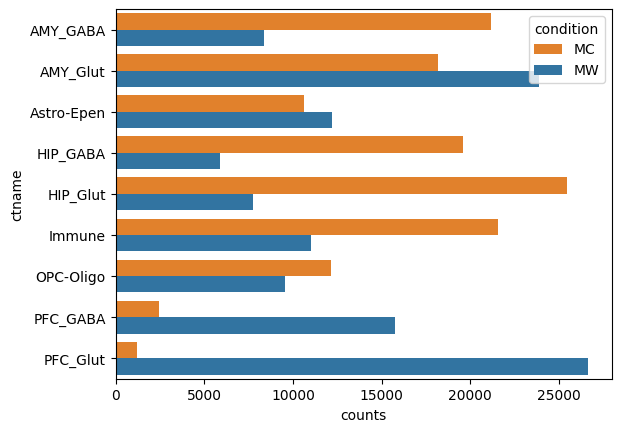

In [9]:
sns.barplot(data=df_counts, y='ctname', x='counts', hue='condition', palette=['#FF7F0E','#1F77B4'], dodge=True,ci=None)
#plt.xlim(0, 5000)

/tmp/ipykernel_3682885/3047026108.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.catplot(x="condition",y='counts', hue="condition",estimator='sum',ci=None, col="region",order=['MW','MC'],hue_order=['MC','MW'], data=df_counts, kind="bar", height=4, aspect=1.5,sharey=False)


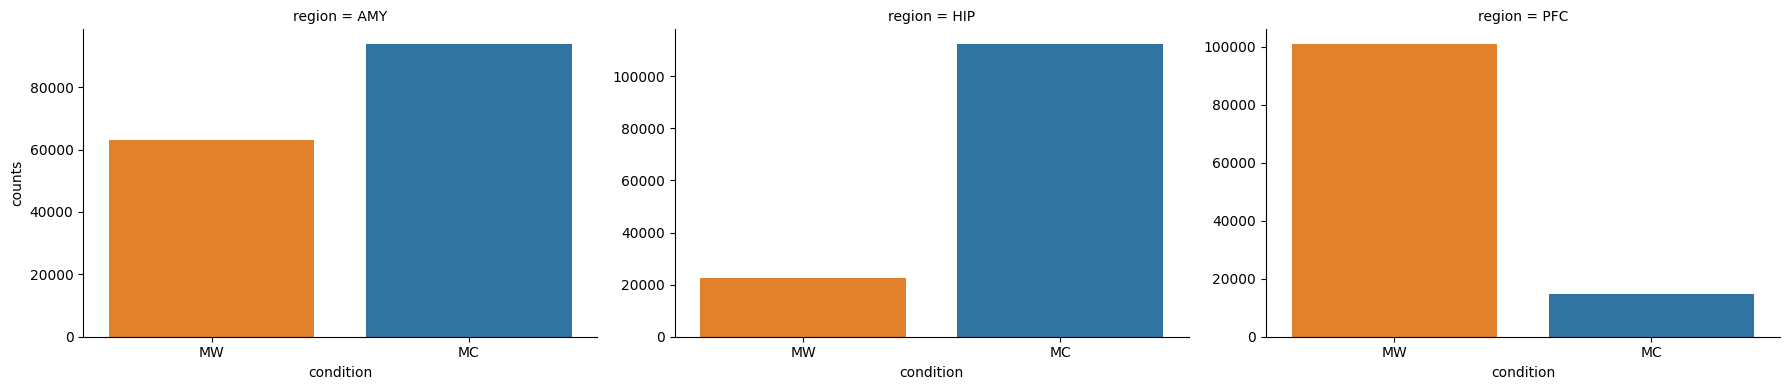

In [10]:
sns.catplot(x="condition",y='counts', hue="condition",estimator='sum',ci=None, col="region",order=['MW','MC'],hue_order=['MC','MW'], data=df_counts, kind="bar", height=4, aspect=1.5,sharey=False)

In [11]:
rejected, adjusted_pvals, _, _ = multipletests(df_annotattion.de_pval, method='fdr_bh')

In [12]:
df_annotattion['de_pval_adj'] = adjusted_pvals

In [13]:
df_annotattion.names.str.split(r"[:-]",expand=True).to_csv(f"{folder}{method}_dar.bed",index=False,header=False, sep="\t")


In [14]:
dict_annot = {}
for file in annotations:
    name = file.split('/')[-1].replace('.bed', '')
    try:
        inte_dar_intron,non_overlapping_in = intersect_bed_files(f"{folder}{method}_dar.bed", file)
        df_annot = inte_dar_intron.to_dataframe()
        df_annot['names'] = df_annot["chrom"] + ":" + df_annot["start"].astype(str) + "-" + df_annot['end'].astype(str)
        df_annot['gene_name'] = df_annot['itemRgb']
        df_annot['cCRE'] = name
        dict_annot[name] = df_annot
        print(f"Processed {file},{len(dict_annot[name])}")
    except Exception as e:
        print(f"Error processing {file}, {e}")
        continue


Processed /data2st1/junyi/generegion_vM23/intron_selected.bed,936711
Processed /data2st1/junyi/generegion_vM23/exon_selected.bed,797294
Processed /data2st1/junyi/generegion_vM23/promoter2k.bed,403960
Processed /data2st1/junyi/output/atac0416/cCRE/LINE.bed,18303
Processed /data2st1/junyi/output/atac0416/cCRE/SINE.bed,67786
Processed /data2st1/junyi/output/atac0416/cCRE/LTR.bed,24830
Processed /data2st1/junyi/output/atac0416/cCRE/cpg.bed,178522
Processed /data2st1/junyi/output/atac0416/cCRE/Other_repeats.bed,164389


***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic

***** WARNING: File /data2st1/junyi/generegion_vM23/UTR.bed has inconsistent naming convention for record:
KZ289081.1	123732	123914	.	+	Slfn2	ENSMUSG00000116022.1	basic



Processed /data2st1/junyi/generegion_vM23/UTR.bed,451334


***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS

***** WARNING: File /data2st1/junyi/generegion_vM23/CDS.bed has inconsistent naming convention for record:
KZ289080.1	76374	76525	.	-	LT629147.3	ENSMUSG00000116214.1	CDS



Processed /data2st1/junyi/generegion_vM23/CDS.bed,264784


***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody

***** WARNING: File /data2st1/junyi/generegion_vM23/genebody.bed has inconsistent naming convention for record:
KZ289080.1	7804	8459	.	-	LT629147.1	ENSMUSG00000115879.1	genebody



Processed /data2st1/junyi/generegion_vM23/genebody.bed,396842
Processed /data2st1/junyi/output/atac0416/cCRE/intergenic.bed,252702


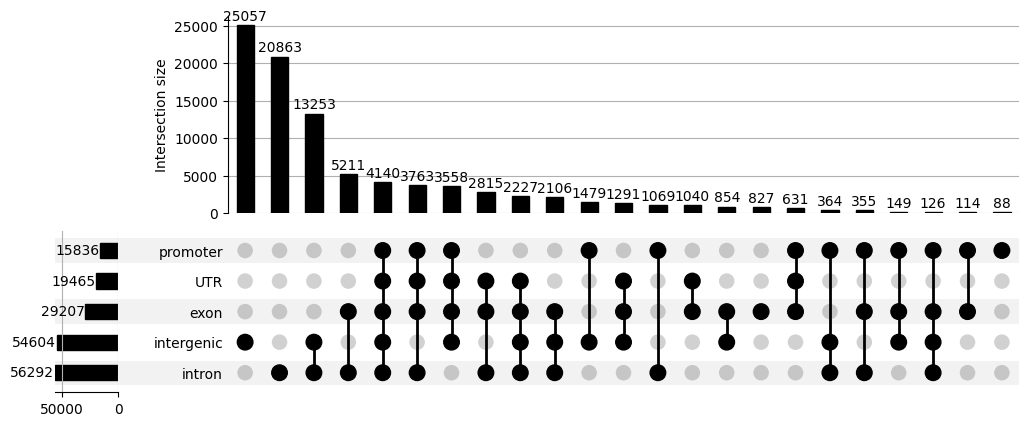

In [15]:
memento_primary_regions = {
    'intron': set(dict_annot['intron_selected'].names),
    'exon': set(dict_annot['exon_selected'].names),
    'promoter': set(dict_annot['promoter2k'].names),
    'UTR': set(dict_annot['UTR'].names),
    'intergenic': set(dict_annot['intergenic'].names),
    # 'LINE': set(dict_annot['LINE'].names+"_"+dict_annot['LINE'].gene_name),
    # 'SINE': set(dict_annot['SINE'].names+"_"+dict_annot['SINE'].gene_name),
    # 'LTR': set(dict_annot['LTR'].names+"_"+dict_annot['LTR'].gene_name),
    # 'repeat': set(dict_annot['Other_repeats'].names+"_"+dict_annot['Other_repeats'].gene_name),
    # 'cpg': set(dict_annot['cpg'].names+"_"+dict_annot['cpg'].gene_name)

    # 'intron': set(dict_annot['intron_selected'].names),
    # 'exon': set(dict_annot['exon_selected'].names),
    # 'promoter': set(dict_annot['promoter2k'].names),
    # 'UTR': set(dict_annot['UTR'].names),
    # 'repeat': set(dict_annot['repeat'].names),
    # 'cpg': set(dict_annot['cpg'].names),
}
memento_primary_regions = from_contents(memento_primary_regions)
ax_dict = UpSet(memento_primary_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()

In [16]:
df_memnto_primary = memento_primary_regions.reset_index()
df_memnto_primary = get_proity_region(df_memnto_primary)

In [17]:
df_memnto_primary.rename(columns={'id': 'names'}, inplace=True)
df_memnto_primary.set_index('names', inplace=True)
df_merge = df_annotattion.merge(df_memnto_primary[['annotation']], on="names", how="left")

df_merge.loc[((df_merge.annotation_y.isna()) | (df_merge.annotation_y=="intergenic")) & (df_merge.apply(is_promoter, axis=1)),"annotation_y"] = "promoter"
df_merge.loc[((df_merge.annotation_y.isna()) | (df_merge.annotation_y=="intergenic")) & (df_merge.strand=="+") & (df_merge.distance<0),"annotation_y"] = "downstream"
df_merge.loc[((df_merge.annotation_y.isna()) | (df_merge.annotation_y=="intergenic")) & (df_merge.strand=="-") & (df_merge.distance>0),"annotation_y"] = "downstream"
df_merge.loc[((df_merge.annotation_y.isna()) | (df_merge.annotation_y=="intergenic")) & (df_merge.strand=="+") & (df_merge.distance>2000),"annotation_y"] = "distal"
df_merge.loc[((df_merge.annotation_y.isna()) | (df_merge.annotation_y=="intergenic")) & (df_merge.strand=="-") & (df_merge.distance<-2000),"annotation_y"] = "distal"
#assert df_merge[df_merge.annotation_y=="intergenic"].distance.values.min() == df_merge[df_merge.annotation_y=="intergenic"].distance.values.max() ==0
df_merge.loc[(df_merge.annotation_x=="genebody") & (df_merge.distance==0) & ((df_merge.annotation_y.isna()) | (df_merge.annotation_y=="intergenic")),"annotation_y"] = "genebody"
df_merge.rename(columns={"annotation_y":"primary_region"}, inplace=True)

<Axes: ylabel='counts'>

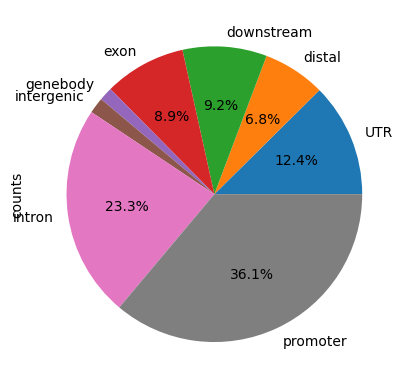

In [18]:
df_memnto_primary_c = df_merge.groupby(['primary_region']).size().reset_index(name='counts')
df_memnto_primary_c.set_index('primary_region').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

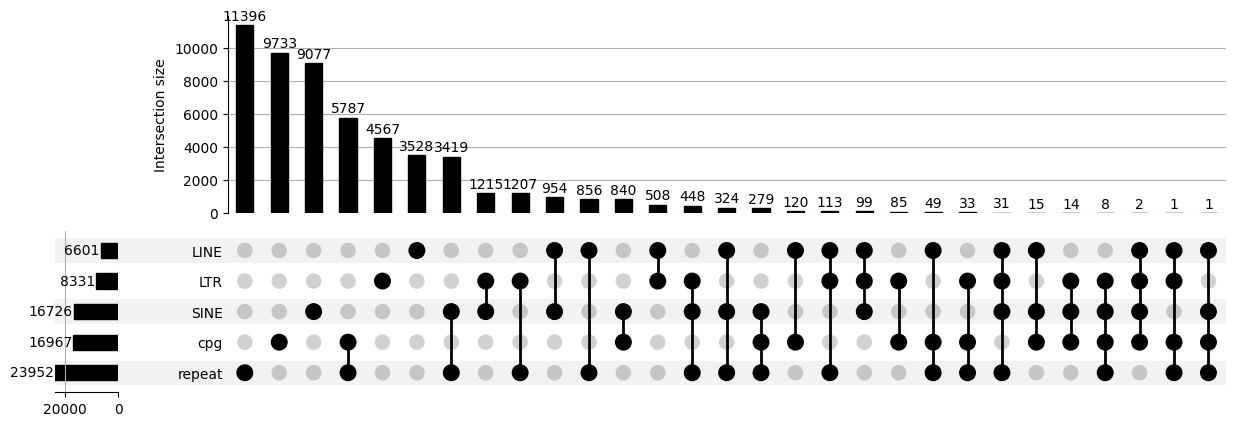

In [19]:
memento_secondary_regions = {
    'LINE': set(dict_annot['LINE'].names),
    'SINE': set(dict_annot['SINE'].names),
    'LTR': set(dict_annot['LTR'].names),
    'repeat': set(dict_annot['Other_repeats'].names),
    'cpg': set(dict_annot['cpg'].names)
}
memento_secondary_regions = from_contents(memento_secondary_regions)
ax_dict = UpSet(memento_secondary_regions, subset_size="count", sort_by="cardinality", show_counts=True).plot()


In [20]:
df_memnto_secondary_regions = memento_secondary_regions.reset_index()
second_priority =[
    "cpg",
    "LTR",
    "LINE",
    "SINE",
    "repeat"
]
df_memnto_secondary_regions = get_proity_region(df_memnto_secondary_regions,priority=second_priority)
df_memnto_secondary_regions.rename(columns={"id":"names","annotation":"secondary_region"}, inplace=True)

In [21]:
df_2nd_merge = df_merge.merge(df_memnto_secondary_regions[["names",'secondary_region']], on="names", how="left")

<Axes: ylabel='counts'>

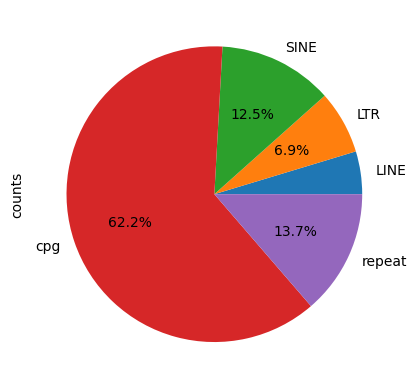

In [22]:
df_2nd_merge_c = df_2nd_merge.groupby(['secondary_region']).size().reset_index(name='counts')
df_2nd_merge_c.set_index('secondary_region').plot.pie(
    y='counts',
    autopct=lambda p: f'{p:.1f}%' if p >= 5 else '',
    legend=False
)

In [23]:
df_2nd_merge.to_csv(f"{folder}{method}_dar_annotated.csv",index=False)